# Classification

**MODELS**

1. Logistic
2. K-Nearest Neighbor
3. SVC
4. Naive Bayes
5. Decision Tree
6. Random Forest
7. AdaBoost
8. XGBoost
9. CATBoost

USING

- Robust Scaler
- One Hot Encoder
- Ordinal Encoder (for `month` need to convert to `str` as `OrdinalEncoder` does not allow sequence for `numeric` type)
- Label Encoder
- Column Transformer
- Pipeline
- GridSearchCV
- metrics (recall- as predicting fire as not-fire has more negative effect)

NOTE

- For using `sklearn.Pipeline` we can add all scalers, encoders and finally model.


[CATBOOST](https://catboost.ai)

- CatBoost builds upon the theory of decision trees and gradient boosting.
- CatBoost grows [oblivious trees](https://en.wikipedia.org/wiki/Oblivious_data_structure#Oblivious_Tree), which means that the trees are grown by imposing the rule that all nodes at the same level, test the same predictor with the same condition, and hence an index of a leaf can be calculated with bitwise operations.
- The oblivious tree procedure allows for a simple fitting scheme and efficiency on CPUs, while the tree structure operates as a regularization to find an optimal solution and avoid overfitting.

References

- https://dataaspirant.com/catboost-algorithm/#t-1609567161983
- https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329
- https://www.geeksforgeeks.org/catboost-ml/


# Importing Libraries


## General Libraries


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

sns.set_theme(style="darkgrid", font_scale=1.4)
warnings.filterwarnings("ignore")


## Miscellaneous Libraries


In [2]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)


## Model Libraries


In [3]:
from sklearn.linear_model import LogisticRegression  # // can use CV but not using due to GridSearchCV approach
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# Importing Dataset


In [4]:
train_data = pd.read_csv("./../data/final_data/classification_train.csv")
test_data = pd.read_csv("./../data/final_data/classification_test.csv")


In [5]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]


In [6]:
X_train.head()


,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,Region
0,8,Jun,30,73,15,0.0,86.6,12.1,38.3,5.6,Bejaia
1,13,Aug,35,63,15,0.0,87.0,19.0,85.1,5.9,Bejaia
2,14,Jul,37,37,18,0.2,88.9,12.9,14.6,9.0,Sidi-Bel Abbes
3,27,Jul,36,48,13,0.0,90.3,22.2,108.5,8.7,Bejaia
4,24,Sep,29,65,19,0.6,68.3,5.5,15.2,1.5,Bejaia


In [7]:
y_train.head()


0        fire
1        fire
2        fire
3        fire
4    not fire
Name: Classes, dtype: object

# Label Encoder


In [8]:
label_encoder = LabelEncoder()
y_train_encoder = label_encoder.fit_transform(y_train)
y_test_encoder = label_encoder.transform(y_test)

label_encoder.classes_


array(['fire', 'not fire'], dtype=object)

In [9]:
y_train = y_train.map({"not fire": 0, "fire": 1})
y_test = y_test.map({"not fire": 0, "fire": 1})


# Model Evaluator


In [10]:
transformer = ColumnTransformer(
    transformers=[
        ("robust_scaler", RobustScaler(), [2, 3, 4, 5, 6, 7, 8, 9]),
        ("ohe_day", OneHotEncoder(sparse=False, drop="first"), [0]),
        ("ord_month", OrdinalEncoder(categories=[["Sep", "Jun", "Jul", "Aug"]]), [1]),
        ("ohe_binary", OneHotEncoder(sparse=False, drop="if_binary"), [-1]),
    ],
    remainder="passthrough",
)


class ModelEvaluate:
    __model_names = []
    __model_report = []

    def __init__(self, model_obj, model_name: str):
        self.__unique_model_name(model_name)
        self.model_obj = model_obj
        self.model_name = model_name
        self.transformers = transformer
        self.gscv = None
        self.pipe = None

    def initialize_gscv(
        self, params, *, scoring="accuracy", cv=5
    ):  # final selection will be using recall as False Negative can have greater effect
        self.gscv = GridSearchCV(
            self.model_obj, param_grid=params, scoring=scoring, cv=cv, verbose=1
        )  # refit is true as we want to see Confusion Matrix from x_test prediction

    def initialize_pipeline(self):
        # Not all Model requires scaling
        self.pipe = Pipeline(steps=[("Transformers", self.transformers), ("gscv", self.gscv)])

    def fit_pipeline(self, X, y):
        self.pipe.fit(X, y)
        self.__model_report.append(
            {"Model Name": self.model_name, "Training Score (accuracy)": self.pipe.named_steps["gscv"].best_score_}
        )
        return self.get_best()

    def get_best(self):
        return {"score": self.pipe.named_steps["gscv"].best_score_, "param": self.pipe.named_steps["gscv"].best_params_}

    def get_cm(self, test_data, true_data):
        pred_data = self.pipe.predict(test_data)
        cm = confusion_matrix(true_data, pred_data)
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        fig.suptitle(f"Confusion Matrix: {self.model_name}")
        ax.set_title(f"F1 Score: {f1_score(true_data,pred_data):.2f}")
        cm_plot = sns.heatmap(
            cm,
            ax=ax,
            cbar=False,
            cmap="YlOrRd",
            annot=True,
            xticklabels=["not fire", "fire"],
            yticklabels=["not fire", "fire"],
            # xticklabels=label_encoder.classes_,
            # yticklabels=label_encoder.classes_,
        )
        ax.set_xlabel("Predicted Values")
        ax.set_ylabel("Actual Values")
        self.__model_report[self.__model_names.index(self.model_name)]["Testing Recall"] = recall_score(
            true_data, pred_data
        )
        self.__model_report[self.__model_names.index(self.model_name)]["Testing Accuracy"] = accuracy_score(
            true_data, pred_data
        )
        return cm_plot

    def get_model_report(self, test_data, true_data):
        return classification_report(self.pipe.predict(test_data), true_data)

    def __unique_model_name(self, model_name: str):
        if model_name in self.__model_names:
            raise Exception(f"{model_name} already exists. model_name should be unique.")
        self.__model_names.append(model_name)

    @staticmethod
    def get_model_names():
        return ModelEvaluate.__model_names

    @staticmethod
    def get_models_report():
        if ModelEvaluate.__model_report:
            return pd.DataFrame(ModelEvaluate.__model_report)
        return "No Model Evaluated"


## Logistic Regression


--------------------------PIPELINE--------------------------
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
{'score': 0.9692307692307691, 'param': {'C': 1, 'l1_ratio': None, 'max_iter': 50, 'penalty': 'l2', 'random_state': 48, 'solver': 'lbfgs'}}
----------------------CONFUSION MATRIX----------------------


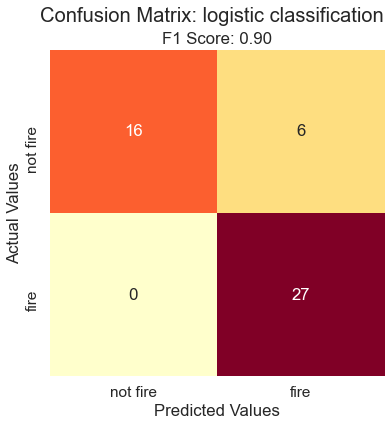

-------------------CLASSIFICATION REPORT--------------------
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        16
           1       1.00      0.82      0.90        33

    accuracy                           0.88        49
   macro avg       0.86      0.91      0.87        49
weighted avg       0.91      0.88      0.88        49



In [11]:
logistic_param = {
    "penalty": ["l2", "elasticnet"],
    "C": [0.4, 0.8, 1, 1.5, 2],
    "solver": ["lbfgs", "liblinear"],
    "max_iter": [50, 100, 200],
    "l1_ratio": [None, 0.4, 0.6, 0.8],
    "random_state": [48, 64],
}
logistic_classifier = ModelEvaluate(LogisticRegression(), "logistic classification")
logistic_classifier.initialize_gscv(logistic_param)
logistic_classifier.initialize_pipeline()
print("PIPELINE".center(60, "-"))
print(logistic_classifier.fit_pipeline(X_train, y_train))
logistic_classifier.get_cm(X_test, y_test)
print("CONFUSION MATRIX".center(60, "-"))
plt.show()
print("CLASSIFICATION REPORT".center(60, "-"))
print(logistic_classifier.get_model_report(X_test, y_test))


## K-Nearest Neighbor (KNN)


--------------------------PIPELINE--------------------------
Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'score': 0.9333333333333333, 'param': {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1}}
----------------------CONFUSION MATRIX----------------------


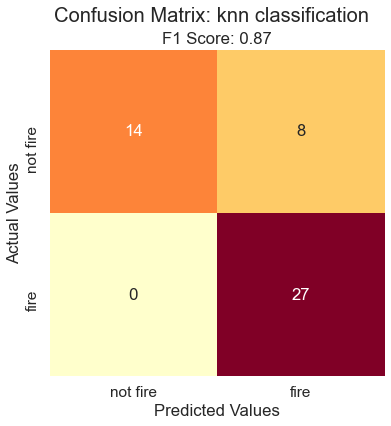

-------------------CLASSIFICATION REPORT--------------------
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        14
           1       1.00      0.77      0.87        35

    accuracy                           0.84        49
   macro avg       0.82      0.89      0.82        49
weighted avg       0.90      0.84      0.84        49



In [12]:
knn_param = {"n_neighbors": [5, 7, 9, 11], "algorithm": ["auto", "ball_tree"], "p": [1, 2]}
knn_classifier = ModelEvaluate(KNeighborsClassifier(), "knn classification")
knn_classifier.initialize_gscv(knn_param)
knn_classifier.initialize_pipeline()
print("PIPELINE".center(60, "-"))
print(knn_classifier.fit_pipeline(X_train, y_train))
knn_classifier.get_cm(X_test, y_test)
print("CONFUSION MATRIX".center(60, "-"))
plt.show()
print("CLASSIFICATION REPORT".center(60, "-"))
print(knn_classifier.get_model_report(X_test, y_test))


## Support Vector Classifier


--------------------------PIPELINE--------------------------
Fitting 5 folds for each of 44 candidates, totalling 220 fits
{'score': 0.9538461538461538, 'param': {'C': 5, 'kernel': 'sigmoid', 'random_state': 48}}
----------------------CONFUSION MATRIX----------------------


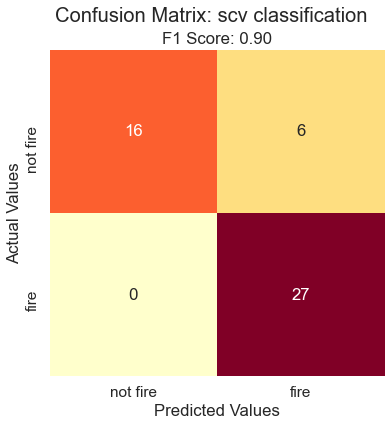

-------------------CLASSIFICATION REPORT--------------------
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        16
           1       1.00      0.82      0.90        33

    accuracy                           0.88        49
   macro avg       0.86      0.91      0.87        49
weighted avg       0.91      0.88      0.88        49



In [13]:
scv_param = {
    "C": [0.01, 0.05, 0.1, 0.4, 0.8, 1, 1.5, 2, 5, 6, 9],
    "kernel": ["sigmoid", "rbf"],
    "random_state": [48, 64],
}
scv_classifier = ModelEvaluate(SVC(), "scv classification")
scv_classifier.initialize_gscv(scv_param)
scv_classifier.initialize_pipeline()
print("PIPELINE".center(60, "-"))
print(scv_classifier.fit_pipeline(X_train, y_train))
scv_classifier.get_cm(X_test, y_test)
print("CONFUSION MATRIX".center(60, "-"))
plt.show()
print("CLASSIFICATION REPORT".center(60, "-"))
print(scv_classifier.get_model_report(X_test, y_test))


## Naive Bayes


--------------------------PIPELINE--------------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'score': 0.7794871794871796, 'param': {}}
----------------------CONFUSION MATRIX----------------------


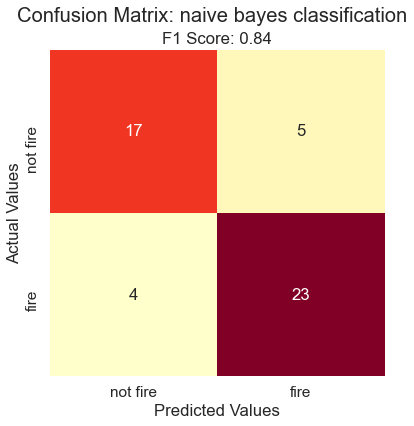

-------------------CLASSIFICATION REPORT--------------------
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.85      0.82      0.84        28

    accuracy                           0.82        49
   macro avg       0.81      0.82      0.81        49
weighted avg       0.82      0.82      0.82        49



In [14]:
naive_bayes_param = {}
naive_bayes_classifier = ModelEvaluate(GaussianNB(), "naive bayes classification")
naive_bayes_classifier.initialize_gscv(naive_bayes_param)
naive_bayes_classifier.initialize_pipeline()
print("PIPELINE".center(60, "-"))
print(naive_bayes_classifier.fit_pipeline(X_train, y_train))
naive_bayes_classifier.get_cm(X_test, y_test)
print("CONFUSION MATRIX".center(60, "-"))
plt.show()
print("CLASSIFICATION REPORT".center(60, "-"))
print(naive_bayes_classifier.get_model_report(X_test, y_test))


## Decision Tree


--------------------------PIPELINE--------------------------
Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'score': 0.9897435897435898, 'param': {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'random_state': 48}}
----------------------CONFUSION MATRIX----------------------


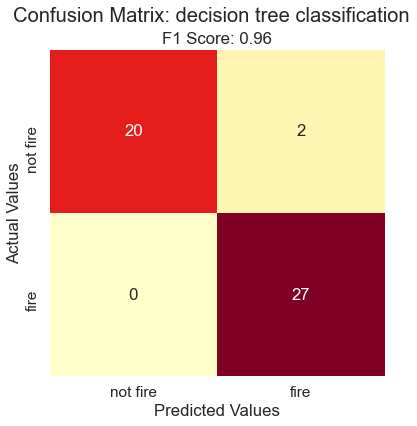

-------------------CLASSIFICATION REPORT--------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.93      0.96        29

    accuracy                           0.96        49
   macro avg       0.95      0.97      0.96        49
weighted avg       0.96      0.96      0.96        49



In [15]:
decision_tree_param = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 4, 5],
    "max_features": [None, "sqrt", "log2"],
    "random_state": [48, 64],
}  # gini has better output compare to entropy in most of the cases and difference would be 1-5%
decision_tree_classifier = ModelEvaluate(DecisionTreeClassifier(), "decision tree classification")
decision_tree_classifier.initialize_gscv(decision_tree_param)
decision_tree_classifier.initialize_pipeline()
print("PIPELINE".center(60, "-"))
print(decision_tree_classifier.fit_pipeline(X_train, y_train))
decision_tree_classifier.get_cm(X_test, y_test)
print("CONFUSION MATRIX".center(60, "-"))
plt.show()
print("CLASSIFICATION REPORT".center(60, "-"))
print(decision_tree_classifier.get_model_report(X_test, y_test))


## Random Forest


--------------------------PIPELINE--------------------------
Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'score': 0.9897435897435898, 'param': {'max_depth': 2, 'max_features': 'log2', 'n_estimators': 100, 'random_state': 64}}
----------------------CONFUSION MATRIX----------------------


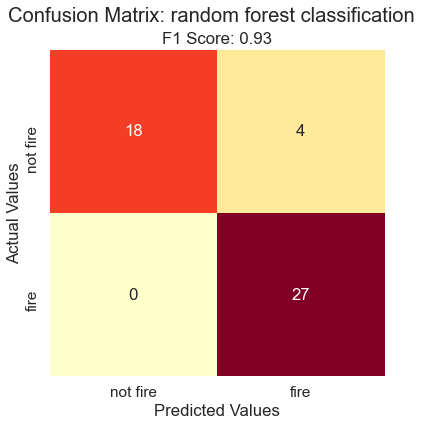

-------------------CLASSIFICATION REPORT--------------------
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        18
           1       1.00      0.87      0.93        31

    accuracy                           0.92        49
   macro avg       0.91      0.94      0.92        49
weighted avg       0.93      0.92      0.92        49



In [16]:
random_forest_param = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 2, 4, 6],
    "max_features": [None, "sqrt", "log2"],
    "random_state": [48, 64],
}
random_forest_classifier = ModelEvaluate(RandomForestClassifier(), "random forest classification")
random_forest_classifier.initialize_gscv(random_forest_param)
random_forest_classifier.initialize_pipeline()
print("PIPELINE".center(60, "-"))
print(random_forest_classifier.fit_pipeline(X_train, y_train))
random_forest_classifier.get_cm(X_test, y_test)
print("CONFUSION MATRIX".center(60, "-"))
plt.show()
print("CLASSIFICATION REPORT".center(60, "-"))
print(random_forest_classifier.get_model_report(X_test, y_test))


## AdaBoost


--------------------------PIPELINE--------------------------
Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'score': 0.9794871794871796, 'param': {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 48}}
----------------------CONFUSION MATRIX----------------------


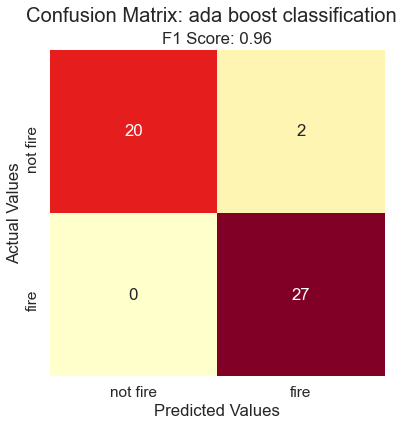

-------------------CLASSIFICATION REPORT--------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.93      0.96        29

    accuracy                           0.96        49
   macro avg       0.95      0.97      0.96        49
weighted avg       0.96      0.96      0.96        49



In [17]:
ada_boost_param = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [0.1, 0.3, 0.5, 0.8, 1, 1.2],
    "random_state": [48, 64],
}
ada_boost_classifier = ModelEvaluate(AdaBoostClassifier(), "ada boost classification")
ada_boost_classifier.initialize_gscv(ada_boost_param)
ada_boost_classifier.initialize_pipeline()
print("PIPELINE".center(60, "-"))
print(ada_boost_classifier.fit_pipeline(X_train, y_train))
ada_boost_classifier.get_cm(X_test, y_test)
print("CONFUSION MATRIX".center(60, "-"))
plt.show()
print("CLASSIFICATION REPORT".center(60, "-"))
print(ada_boost_classifier.get_model_report(X_test, y_test))


## XGBoost


--------------------------PIPELINE--------------------------
Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'score': 0.9846153846153847, 'param': {'eval_metric': 'error', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'random_state': 48}}
----------------------CONFUSION MATRIX----------------------


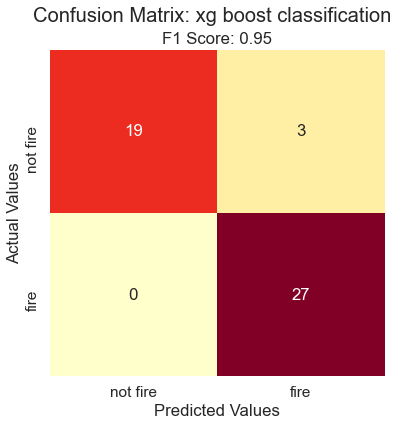

-------------------CLASSIFICATION REPORT--------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        19
           1       1.00      0.90      0.95        30

    accuracy                           0.94        49
   macro avg       0.93      0.95      0.94        49
weighted avg       0.95      0.94      0.94        49



In [18]:
xg_boost_param = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [2, 4, 6],
    "learning_rate": [0.1, 0.3, 0.5, 0.8, 1, 1.2],
    "eval_metric": ["error"],
    "random_state": [48, 64],
}
xg_boost_classifier = ModelEvaluate(XGBClassifier(), "xg boost classification")
xg_boost_classifier.initialize_gscv(xg_boost_param)
xg_boost_classifier.initialize_pipeline()
print("PIPELINE".center(60, "-"))
print(xg_boost_classifier.fit_pipeline(X_train, y_train))
xg_boost_classifier.get_cm(X_test, y_test)
print("CONFUSION MATRIX".center(60, "-"))
plt.show()
print("CLASSIFICATION REPORT".center(60, "-"))
print(xg_boost_classifier.get_model_report(X_test, y_test))


## CATBoost


--------------------------PIPELINE--------------------------
Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'score': 0.9846153846153847, 'param': {'depth': 2, 'iterations': 150, 'learning_rate': 0.1, 'random_seed': 48, 'verbose': False}}
----------------------CONFUSION MATRIX----------------------


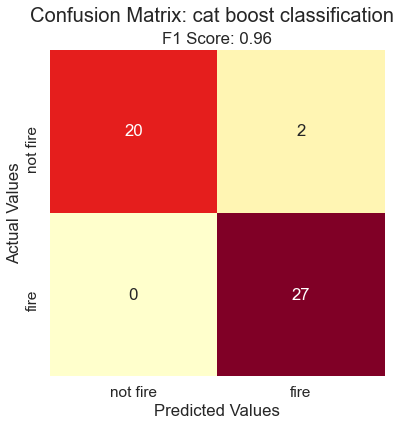

-------------------CLASSIFICATION REPORT--------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.93      0.96        29

    accuracy                           0.96        49
   macro avg       0.95      0.97      0.96        49
weighted avg       0.96      0.96      0.96        49



In [19]:
cat_boost_param = {
    "iterations": [150, 300, 500],
    "learning_rate": [0.1, 0.3, 0.5, 0.8, 1],
    "depth": [2, 4, 6],
    "random_seed": [48, 64],
    "verbose": [False],
}  # has sklearn synonyms of parameter
cat_boost_classifier = ModelEvaluate(CatBoostClassifier(), "cat boost classification")
cat_boost_classifier.initialize_gscv(cat_boost_param)
cat_boost_classifier.initialize_pipeline()
print("PIPELINE".center(60, "-"))
print(cat_boost_classifier.fit_pipeline(X_train, y_train))
cat_boost_classifier.get_cm(X_test, y_test)
print("CONFUSION MATRIX".center(60, "-"))
plt.show()
print("CLASSIFICATION REPORT".center(60, "-"))
print(cat_boost_classifier.get_model_report(X_test, y_test))


# Model Report


In [20]:
model_report = ModelEvaluate.get_models_report()
model_report


,Model Name,Training Score (accuracy),Testing Recall,Testing Accuracy
0,logistic classification,0.969231,1.000000,0.877551
1,knn classification,0.933333,1.000000,0.836735
2,scv classification,0.953846,1.000000,0.877551
3,naive bayes classification,0.779487,0.851852,0.816327
4,decision tree classification,0.989744,1.000000,0.959184
5,random forest classification,0.989744,1.000000,0.918367
6,ada boost classification,0.979487,1.000000,0.959184
7,xg boost classification,0.984615,1.000000,0.938776
8,cat boost classification,0.984615,1.000000,0.959184


In [21]:
model_report.sort_values([model_report.columns[2], model_report.columns[3], model_report.columns[1]], ascending=False)


,Model Name,Training Score (accuracy),Testing Recall,Testing Accuracy
4,decision tree classification,0.989744,1.000000,0.959184
8,cat boost classification,0.984615,1.000000,0.959184
6,ada boost classification,0.979487,1.000000,0.959184
7,xg boost classification,0.984615,1.000000,0.938776
5,random forest classification,0.989744,1.000000,0.918367
0,logistic classification,0.969231,1.000000,0.877551
2,scv classification,0.953846,1.000000,0.877551
1,knn classification,0.933333,1.000000,0.836735
3,naive bayes classification,0.779487,0.851852,0.816327


OBSERVATION

- Decision Tree is the Best model according to metrics.
- CATBoost is 2nd Best model.
- Going with CATBoost as Difference between Testing and Training accuracy is less.
- Mathematically CATBoost suits more than Decision Tree.


# Top Model (CATBoost)


In [22]:
cat_boost_classifier.get_best()["param"]


{'depth': 2,
 'iterations': 150,
 'learning_rate': 0.1,
 'random_seed': 48,
 'verbose': False}

In [54]:
X_train.values

array([[8, 'Jun', 30, ..., 38.3, 5.6, 'Bejaia'],
       [13, 'Aug', 35, ..., 85.1, 5.9, 'Bejaia'],
       [14, 'Jul', 37, ..., 14.6, 9.0, 'Sidi-Bel Abbes'],
       ...,
       [28, 'Sep', 32, ..., 8.8, 1.8, 'Bejaia'],
       [17, 'Sep', 34, ..., 63.3, 11.2, 'Sidi-Bel Abbes'],
       [14, 'Aug', 37, ..., 55.5, 10.8, 'Sidi-Bel Abbes']], dtype=object)

In [55]:
y_train.values

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1],
      dtype=int64)

In [76]:
final_pipe = Pipeline(
    steps=[
        ("transformers", transformer),
        ("cat_boost", CatBoostClassifier(depth=2, iterations=150, learning_rate=0.1, random_seed=48, verbose=False)),
    ]
)
final_pipe.fit(X_train.values, y_train.values)
final_pipe.score(X_train.values, y_train.values)


1.0

## Metrics


In [75]:
y_pred = final_pipe.predict(X_test.values)
print(classification_report(y_test.values, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.93      1.00      0.96        27

    accuracy                           0.96        49
   macro avg       0.97      0.95      0.96        49
weighted avg       0.96      0.96      0.96        49



Text(8.499999999999996, 0.5, 'Actual Values')

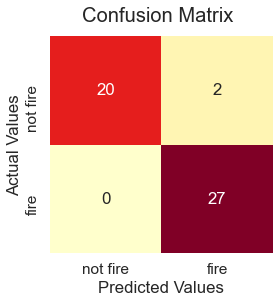

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fig.suptitle(f"Confusion Matrix")
cm_plot = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    ax=ax,
    cbar=False,
    cmap="YlOrRd",
    annot=True,
    xticklabels=["not fire", "fire"],
    yticklabels=["not fire", "fire"],
)
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values")


## ROC & AUROC


In [71]:
y_pred_proba = final_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test.values, y_pred_proba)
auroc = roc_auc_score(y_test.values, y_pred_proba)


## Decision Tree


In [72]:
temp_pipe = Pipeline(
    steps=[
        ("transformer", transformer),
        ("decision_tree", DecisionTreeClassifier(max_features="sqrt", random_state=48)),
    ]
)
temp_pipe.fit(X_train, y_train)


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robust_scaler',
                                                  RobustScaler(),
                                                  [2, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('ohe_day',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  [0]),
                                                 ('ord_month',
                                                  OrdinalEncoder(categories=[['Sep',
                                                                              'Jun',
                                                                              'Jul',
                                                                              'Aug']]),
                                                  [1]),
                                                 ('ohe_binary',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  [-1])])),
                ('decision_tree',
                 DecisionTreeClassifier(max_features='sqrt', random_state=48))])

In [73]:
y_pred_dt_proba = temp_pipe.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test, y_pred_dt_proba)
auroc_dt = roc_auc_score(y_test, y_pred_dt_proba)


## Graph


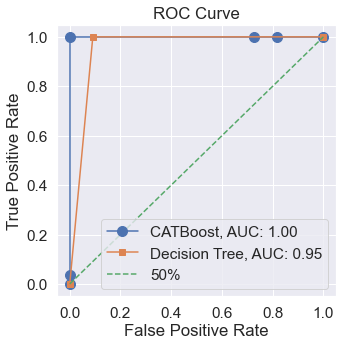

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(fpr, tpr, "o-", ms=10, label=f"CATBoost, AUC: {auroc:.2f}")
ax.plot(fpr_dt, tpr_dt, "s-", label=f"Decision Tree, AUC: {auroc_dt:.2f}")
ax.plot(fpr, fpr, "g--", label="50%")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC Curve")
ax.legend()
plt.show()

# print(f"Threshold CATBoost: {threshold[np.argmax(tpr - fpr)]}")
# print(f"Threshold Decision Tree: {threshold_dt[np.argmax(tpr_dt - fpr_dt)]}")

In [64]:
X_test.iloc[0].to_dict()

{'day': 21,
 'month': 'Aug',
 'Temperature': 36,
 'RH': 58,
 'Ws': 19,
 'Rain': 0.0,
 'FFMC': 88.6,
 'DMC': 29.6,
 'DC': 141.1,
 'ISI': 9.2,
 'Region': 'Bejaia'}

In [65]:
b = {
    "day": 21,
    "month": "Aug",
    "Temperature": 36,
    "RH": 58,
    "Ws": 19,
    "Rain": 0.0,
    "FFMC": 88.6,
    "DMC": 29.6,
    "DC": 141.1,
    "ISI": 9.2,
    "Region": "Bejaia",
}


In [66]:
x_data=[list(b.values())]
x_data

[[21, 'Aug', 36, 58, 19, 0.0, 88.6, 29.6, 141.1, 9.2, 'Bejaia']]

In [67]:
final_pipe.predict(x_data)

array([1], dtype=int64)

In [68]:
final_pipe.predict(X_test.iloc[[0]])

array([1], dtype=int64)

# Serializing Model


In [77]:
import pickle
import os

if not os.path.isdir("./../model"):
    os.mkdir("./../model")

with open("./../model/classification_pipeline.pkl", "wb") as f:
    pickle.dump(final_pipe, f)


# (ROUGH)


## Confusion Matrix


In [36]:
a = [0, 1, 0, 0, 1, 1, 0]
b = [0, 1, 0, 1, 0, 0, 0]


In [37]:
confusion_matrix(a, b)


array([[3, 1],
       [2, 1]], dtype=int64)

In [38]:
tn, fp, fn, tp = confusion_matrix(a, b).ravel()
(tn, fp, fn, tp)


(3, 1, 2, 1)

## np.argmin / np.argmax

In [39]:
a=np.array([1,2,3])
b=np.array([5,10,15])
b-a,np.argmax(b-a),np.argmin(b-a)

(array([ 4,  8, 12]), 2, 0)